See code at https://github.com/google-research/vision_transformer/

This Colab is about the paper

- LiT: Zero-Shot Transfer with Locked-image text Tuning: https://arxiv.org/abs/2111.07991

For ViT, MLP Mixer etc see the other Colab

https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb

### Load model

In [1]:
# Installs the vit_jax package from Github.
!pip install -q git+https://github.com/google-research/vision_transformer

     |████████████████████████████████| 92 kB 583 kB/s 
     |████████████████████████████████| 197 kB 9.2 MB/s 
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 4.6 MB 27.4 MB/s 
     |████████████████████████████████| 288 kB 48.2 MB/s 
     |████████████████████████████████| 4.3 MB 48.6 MB/s 
     |████████████████████████████████| 140 kB 61.3 MB/s 
     |████████████████████████████████| 216 kB 65.9 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
     |████████████████████████████████| 98 kB 7.5 MB/s 
     |████████████████████████████████| 72 kB 593 kB/s 
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 511.7 MB 4.4 kB/s 
     |████████████████████████████████| 4.9 MB 48.1 MB/s 


In [2]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm

from vit_jax import models


In [3]:
# Currently available LiT models
[name for name in models.model_configs.MODEL_CONFIGS if name.startswith('LiT')]

['LiT-B16B', 'LiT-L16L', 'LiT-L16S', 'LiT-L16Ti']

In [4]:
model_name = 'LiT-B16B'

lit_model = models.get_model(model_name)
# Loading the variables from cloud can take a while the first time...
lit_variables = lit_model.load_variables()
# Creating tokens from freeform text (see next section).
tokenizer = lit_model.get_tokenizer()
# Resizing images & converting value range to -1..1 (see next section).
image_preprocessing = lit_model.get_image_preprocessing()
# Preprocessing op for use in tfds pipeline (see last section).
pp = lit_model.get_pp()

Loading params from cloud: gs://vit_models/lit/LiT-B16B.npz


100%|██████████| 75/75 [00:53<00:00,  1.39it/s]



⚠️ Reusing local copy: LiT-B16B.npz


### Use model

In [5]:
# Let's load some sample images from tfds.
# Alternatively you can also load these images from the internet / your Drive.
ds = tfds.load('imagenette', split='train')
images_list = [
    example['image'].numpy()
    for _, example in zip(range(5), ds)
]
# Note that this is a list of images with different shapes, not a four
# dimensional tensor.
[image.shape for image in images_list]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incomplete7T8YUJ/imagenette-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incomplete7T8YUJ/imagenette-validation.tfrecord*…

Dataset imagenette downloaded and prepared to ~/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.


[(101, 125, 3), (375, 500, 3), (335, 500, 3), (429, 500, 3), (359, 500, 3)]

In [6]:
# Note that our preprocessing converts to floats ranging from -1..1 !
images = image_preprocessing(images_list)
images.shape, images.min(), images.max()

((5, 224, 224, 3), -1.0, 1.0)

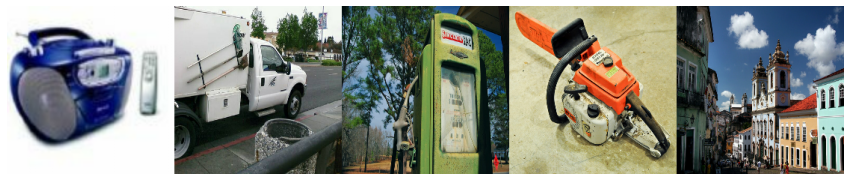

In [7]:
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(images) * .5 + .5)
plt.axis('off');

In [8]:
texts = [
    'itap of a cd player',
    'a photo of a truck',
    'gas station',
    'chainsaw',
    'a bad photo of colorful houses',
]
tokens = tokenizer(texts)
tokens.shape

(5, 16)

In [9]:
# Embed both texts and images with a single model call.
# See next section for embedding images/texts separately.
zimg, ztxt, out = lit_model.apply(lit_variables, images=images, tokens=tokens)

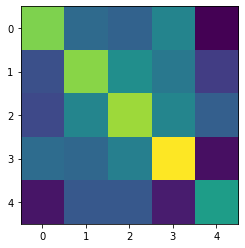

In [10]:
plt.imshow(ztxt @ zimg.T)

In [11]:
probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
pd.DataFrame(probs, index=texts).style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}')

,0,1,2,3,4
itap of a cd player,99.71%,0.04%,0.02%,0.23%,0.00%
a photo of a truck,0.01%,99.55%,0.37%,0.07%,0.00%
gas station,0.00%,0.11%,99.77%,0.11%,0.01%
chainsaw,0.00%,0.00%,0.01%,99.99%,0.00%
a bad photo of colorful houses,0.02%,0.80%,0.82%,0.03%,98.34%


### `tfds` zero-shot evaluation

In [12]:
#@markdown `imagenet_classnames`
# From https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb
imagenet_classnames = "tench;goldfish;great white shark;tiger shark;hammerhead shark;electric ray;stingray;rooster;hen;ostrich;brambling;goldfinch;house finch;junco;indigo bunting;American robin;bulbul;jay;magpie;chickadee;American dipper;kite (bird of prey);bald eagle;vulture;great grey owl;fire salamander;smooth newt;newt;spotted salamander;axolotl;American bullfrog;tree frog;tailed frog;loggerhead sea turtle;leatherback sea turtle;mud turtle;terrapin;box turtle;banded gecko;green iguana;Carolina anole;desert grassland whiptail lizard;agama;frilled-necked lizard;alligator lizard;Gila monster;European green lizard;chameleon;Komodo dragon;Nile crocodile;American alligator;triceratops;worm snake;ring-necked snake;eastern hog-nosed snake;smooth green snake;kingsnake;garter snake;water snake;vine snake;night snake;boa constrictor;African rock python;Indian cobra;green mamba;sea snake;Saharan horned viper;eastern diamondback rattlesnake;sidewinder rattlesnake;trilobite;harvestman;scorpion;yellow garden spider;barn spider;European garden spider;southern black widow;tarantula;wolf spider;tick;centipede;black grouse;ptarmigan;ruffed grouse;prairie grouse;peafowl;quail;partridge;african grey parrot;macaw;sulphur-crested cockatoo;lorikeet;coucal;bee eater;hornbill;hummingbird;jacamar;toucan;duck;red-breasted merganser;goose;black swan;tusker;echidna;platypus;wallaby;koala;wombat;jellyfish;sea anemone;brain coral;flatworm;nematode;conch;snail;slug;sea slug;chiton;chambered nautilus;Dungeness crab;rock crab;fiddler crab;red king crab;American lobster;spiny lobster;crayfish;hermit crab;isopod;white stork;black stork;spoonbill;flamingo;little blue heron;great egret;bittern bird;crane bird;limpkin;common gallinule;American coot;bustard;ruddy turnstone;dunlin;common redshank;dowitcher;oystercatcher;pelican;king penguin;albatross;grey whale;killer whale;dugong;sea lion;Chihuahua;Japanese Chin;Maltese;Pekingese;Shih Tzu;King Charles Spaniel;Papillon;toy terrier;Rhodesian Ridgeback;Afghan Hound;Basset Hound;Beagle;Bloodhound;Bluetick Coonhound;Black and Tan Coonhound;Treeing Walker Coonhound;English foxhound;Redbone Coonhound;borzoi;Irish Wolfhound;Italian Greyhound;Whippet;Ibizan Hound;Norwegian Elkhound;Otterhound;Saluki;Scottish Deerhound;Weimaraner;Staffordshire Bull Terrier;American Staffordshire Terrier;Bedlington Terrier;Border Terrier;Kerry Blue Terrier;Irish Terrier;Norfolk Terrier;Norwich Terrier;Yorkshire Terrier;Wire Fox Terrier;Lakeland Terrier;Sealyham Terrier;Airedale Terrier;Cairn Terrier;Australian Terrier;Dandie Dinmont Terrier;Boston Terrier;Miniature Schnauzer;Giant Schnauzer;Standard Schnauzer;Scottish Terrier;Tibetan Terrier;Australian Silky Terrier;Soft-coated Wheaten Terrier;West Highland White Terrier;Lhasa Apso;Flat-Coated Retriever;Curly-coated Retriever;Golden Retriever;Labrador Retriever;Chesapeake Bay Retriever;German Shorthaired Pointer;Vizsla;English Setter;Irish Setter;Gordon Setter;Brittany dog;Clumber Spaniel;English Springer Spaniel;Welsh Springer Spaniel;Cocker Spaniel;Sussex Spaniel;Irish Water Spaniel;Kuvasz;Schipperke;Groenendael dog;Malinois;Briard;Australian Kelpie;Komondor;Old English Sheepdog;Shetland Sheepdog;collie;Border Collie;Bouvier des Flandres dog;Rottweiler;German Shepherd Dog;Dobermann;Miniature Pinscher;Greater Swiss Mountain Dog;Bernese Mountain Dog;Appenzeller Sennenhund;Entlebucher Sennenhund;Boxer;Bullmastiff;Tibetan Mastiff;French Bulldog;Great Dane;St. Bernard;husky;Alaskan Malamute;Siberian Husky;Dalmatian;Affenpinscher;Basenji;pug;Leonberger;Newfoundland dog;Great Pyrenees dog;Samoyed;Pomeranian;Chow Chow;Keeshond;brussels griffon;Pembroke Welsh Corgi;Cardigan Welsh Corgi;Toy Poodle;Miniature Poodle;Standard Poodle;Mexican hairless dog (xoloitzcuintli);grey wolf;Alaskan tundra wolf;red wolf or maned wolf;coyote;dingo;dhole;African wild dog;hyena;red fox;kit fox;Arctic fox;grey fox;tabby cat;tiger cat;Persian cat;Siamese cat;Egyptian Mau;cougar;lynx;leopard;snow leopard;jaguar;lion;tiger;cheetah;brown bear;American black bear;polar bear;sloth bear;mongoose;meerkat;tiger beetle;ladybug;ground beetle;longhorn beetle;leaf beetle;dung beetle;rhinoceros beetle;weevil;fly;bee;ant;grasshopper;cricket insect;stick insect;cockroach;praying mantis;cicada;leafhopper;lacewing;dragonfly;damselfly;red admiral butterfly;ringlet butterfly;monarch butterfly;small white butterfly;sulphur butterfly;gossamer-winged butterfly;starfish;sea urchin;sea cucumber;cottontail rabbit;hare;Angora rabbit;hamster;porcupine;fox squirrel;marmot;beaver;guinea pig;common sorrel horse;zebra;pig;wild boar;warthog;hippopotamus;ox;water buffalo;bison;ram (adult male sheep);bighorn sheep;Alpine ibex;hartebeest;impala (antelope);gazelle;arabian camel;llama;weasel;mink;European polecat;black-footed ferret;otter;skunk;badger;armadillo;three-toed sloth;orangutan;gorilla;chimpanzee;gibbon;siamang;guenon;patas monkey;baboon;macaque;langur;black-and-white colobus;proboscis monkey;marmoset;white-headed capuchin;howler monkey;titi monkey;Geoffroy's spider monkey;common squirrel monkey;ring-tailed lemur;indri;Asian elephant;African bush elephant;red panda;giant panda;snoek fish;eel;silver salmon;rock beauty fish;clownfish;sturgeon;gar fish;lionfish;pufferfish;abacus;abaya;academic gown;accordion;acoustic guitar;aircraft carrier;airliner;airship;altar;ambulance;amphibious vehicle;analog clock;apiary;apron;trash can;assault rifle;backpack;bakery;balance beam;balloon;ballpoint pen;Band-Aid;banjo;baluster / handrail;barbell;barber chair;barbershop;barn;barometer;barrel;wheelbarrow;baseball;basketball;bassinet;bassoon;swimming cap;bath towel;bathtub;station wagon;lighthouse;beaker;military hat (bearskin or shako);beer bottle;beer glass;bell tower;baby bib;tandem bicycle;bikini;ring binder;binoculars;birdhouse;boathouse;bobsleigh;bolo tie;poke bonnet;bookcase;bookstore;bottle cap;hunting bow;bow tie;brass memorial plaque;bra;breakwater;breastplate;broom;bucket;buckle;bulletproof vest;high-speed train;butcher shop;taxicab;cauldron;candle;cannon;canoe;can opener;cardigan;car mirror;carousel;tool kit;cardboard box / carton;car wheel;automated teller machine;cassette;cassette player;castle;catamaran;CD player;cello;mobile phone;chain;chain-link fence;chain mail;chainsaw;storage chest;chiffonier;bell or wind chime;china cabinet;Christmas stocking;church;movie theater;cleaver;cliff dwelling;cloak;clogs;cocktail shaker;coffee mug;coffeemaker;spiral or coil;combination lock;computer keyboard;candy store;container ship;convertible;corkscrew;cornet;cowboy boot;cowboy hat;cradle;construction crane;crash helmet;crate;infant bed;Crock Pot;croquet ball;crutch;cuirass;dam;desk;desktop computer;rotary dial telephone;diaper;digital clock;digital watch;dining table;dishcloth;dishwasher;disc brake;dock;dog sled;dome;doormat;drilling rig;drum;drumstick;dumbbell;Dutch oven;electric fan;electric guitar;electric locomotive;entertainment center;envelope;espresso machine;face powder;feather boa;filing cabinet;fireboat;fire truck;fire screen;flagpole;flute;folding chair;football helmet;forklift;fountain;fountain pen;four-poster bed;freight car;French horn;frying pan;fur coat;garbage truck;gas mask or respirator;gas pump;goblet;go-kart;golf ball;golf cart;gondola;gong;gown;grand piano;greenhouse;radiator grille;grocery store;guillotine;hair clip;hair spray;half-track;hammer;hamper;hair dryer;hand-held computer;handkerchief;hard disk drive;harmonica;harp;combine harvester;hatchet;holster;home theater;honeycomb;hook;hoop skirt;gymnastic horizontal bar;horse-drawn vehicle;hourglass;iPod;clothes iron;carved pumpkin;jeans;jeep;T-shirt;jigsaw puzzle;rickshaw;joystick;kimono;knee pad;knot;lab coat;ladle;lampshade;laptop computer;lawn mower;lens cap;letter opener;library;lifeboat;lighter;limousine;ocean liner;lipstick;slip-on shoe;lotion;music speaker;loupe magnifying glass;sawmill;magnetic compass;messenger bag;mailbox;tights;one-piece bathing suit;manhole cover;maraca;marimba;mask;matchstick;maypole;maze;measuring cup;medicine cabinet;megalith;microphone;microwave oven;military uniform;milk can;minibus;miniskirt;minivan;missile;mitten;mixing bowl;mobile home;ford model t;modem;monastery;monitor;moped;mortar and pestle;graduation cap;mosque;mosquito net;vespa;mountain bike;tent;computer mouse;mousetrap;moving van;muzzle;metal nail;neck brace;necklace;baby pacifier;notebook computer;obelisk;oboe;ocarina;odometer;oil filter;pipe organ;oscilloscope;overskirt;bullock cart;oxygen mask;product packet / packaging;paddle;paddle wheel;padlock;paintbrush;pajamas;palace;pan flute;paper towel;parachute;parallel bars;park bench;parking meter;railroad car;patio;payphone;pedestal;pencil case;pencil sharpener;perfume;Petri dish;photocopier;plectrum;Pickelhaube;picket fence;pickup truck;pier;piggy bank;pill bottle;pillow;ping-pong ball;pinwheel;pirate ship;drink pitcher;block plane;planetarium;plastic bag;plate rack;farm plow;plunger;Polaroid camera;pole;police van;poncho;pool table;soda bottle;plant pot;potter's wheel;power drill;prayer rug;printer;prison;missile;projector;hockey puck;punching bag;purse;quill;quilt;race car;racket;radiator;radio;radio telescope;rain barrel;recreational vehicle;fishing casting reel;reflex camera;refrigerator;remote control;restaurant;revolver;rifle;rocking chair;rotisserie;eraser;rugby ball;ruler measuring stick;sneaker;safe;safety pin;salt shaker;sandal;sarong;saxophone;scabbard;weighing scale;school bus;schooner;scoreboard;CRT monitor;screw;screwdriver;seat belt;sewing machine;shield;shoe store;shoji screen / room divider;shopping basket;shopping cart;shovel;shower cap;shower curtain;ski;balaclava ski mask;sleeping bag;slide rule;sliding door;slot machine;snorkel;snowmobile;snowplow;soap dispenser;soccer ball;sock;solar thermal collector;sombrero;soup bowl;keyboard space bar;space heater;space shuttle;spatula;motorboat;spider web;spindle;sports car;spotlight;stage;steam locomotive;through arch bridge;steel drum;stethoscope;scarf;stone wall;stopwatch;stove;strainer;tram;stretcher;couch;stupa;submarine;suit;sundial;sunglasses;sunglasses;sunscreen;suspension bridge;mop;sweatshirt;swim trunks / shorts;swing;electrical switch;syringe;table lamp;tank;tape player;teapot;teddy bear;television;tennis ball;thatched roof;front curtain;thimble;threshing machine;throne;tile roof;toaster;tobacco shop;toilet seat;torch;totem pole;tow truck;toy store;tractor;semi-trailer truck;tray;trench coat;tricycle;trimaran;tripod;triumphal arch;trolleybus;trombone;hot tub;turnstile;typewriter keyboard;umbrella;unicycle;upright piano;vacuum cleaner;vase;vaulted or arched ceiling;velvet fabric;vending machine;vestment;viaduct;violin;volleyball;waffle iron;wall clock;wallet;wardrobe;military aircraft;sink;washing machine;water bottle;water jug;water tower;whiskey jug;whistle;hair wig;window screen;window shade;Windsor tie;wine bottle;airplane wing;wok;wooden spoon;wool;split-rail fence;shipwreck;sailboat;yurt;website;comic book;crossword;traffic or street sign;traffic light;dust jacket;menu;plate;guacamole;consomme;hot pot;trifle;ice cream;popsicle;baguette;bagel;pretzel;cheeseburger;hot dog;mashed potatoes;cabbage;broccoli;cauliflower;zucchini;spaghetti squash;acorn squash;butternut squash;cucumber;artichoke;bell pepper;cardoon;mushroom;Granny Smith apple;strawberry;orange;lemon;fig;pineapple;banana;jackfruit;cherimoya (custard apple);pomegranate;hay;carbonara;chocolate syrup;dough;meatloaf;pizza;pot pie;burrito;red wine;espresso;tea cup;eggnog;mountain;bubble;cliff;coral reef;geyser;lakeshore;promontory;sandbar;beach;valley;volcano;baseball player;bridegroom;scuba diver;rapeseed;daisy;yellow lady's slipper;corn;acorn;rose hip;horse chestnut seed;coral fungus;agaric;gyromitra;stinkhorn mushroom;earth star fungus;hen of the woods mushroom;bolete;corn cob;toilet paper".split(';')


In [13]:
# # For imagenet evaluation, first prepare the dataset on a GCS bucket as
# # described in
# # https://www.tensorflow.org/datasets/catalog/imagenet2012
# # and then replace `data_dir` below with that GCS bucket.
# # If you get a `PermissionDeniedError`, try restarting the kernel.
# from google.colab import auth
# auth.authenticate_user()  # Required to access access protected GCS buckets.
# builder = tfds.builder('imagenet2012', data_dir='gs://tensorflow-datasets/datasets')
# ds_test = builder.as_dataset('validation')
# info = builder.info
# classnames = imagenet_classnames

In [14]:
# Load dataset and create array of class names.
builder = tfds.builder('cifar100')
builder.download_and_prepare()
ds_test = builder.as_dataset('test')
info = builder.info
classnames = [
    info.features['label'].int2str(id_)
    for id_ in range(info.features['label'].num_classes)
]
classnames[:10]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar100/3.0.2.incomplete5GRC1Y/cifar100-train.tfrecord*...:   0%|          | …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar100/3.0.2.incomplete5GRC1Y/cifar100-test.tfrecord*...:   0%|          | 0…

Dataset cifar100 downloaded and prepared to ~/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

In [15]:
#@markdown `PROMPTS80`
PROMPTS80 = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]


In [16]:
# The official CLIP Colab
# https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb
# lists two sets of prompts: the 80 prompts mentioned in the CLIP paper
# (https://arxiv.org/abs/2103.00020), as well as a shortlist of 7 prompts that
# we'll be using by default below.

PROMPTS = [
    'itap of a {}.',
    'a bad photo of the {}.',
    'a origami {}.',
    'a photo of the large {}.',
    'a {} in a video game.',
    'art of the {}.',
    'a photo of the small {}.',
    '{}',
]
# PROMPTS = PROMPTS80

texts = [
    prompt.format(classname)
    for classname in classnames
    for prompt in PROMPTS
]
len(texts)

800

In [17]:
# Tokenize the texts using numpy like before.
tokens = tokenizer(texts)
tokens.shape

(800, 16)

In [18]:
_, ztxt, _ = lit_model.apply(lit_variables, tokens=tokens)
ztxt.shape

(800, 768)

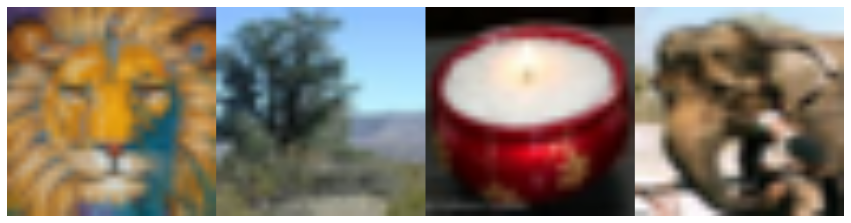

In [19]:
# `pp` from above (section "Load model") is a TensorFlow graph that can
# efficiently be added to the input pre-processing.
imgs = next(iter(ds_test.map(pp).batch(4)))['image']
# Note that `pp` would also tokenize "texts" to "tokens", if such a feature was
# present in the dataset (which is not the case for cifar).

plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(imgs) * .5 + .5)
plt.axis('off');

In [20]:
# JIT-compile image embedding function because there are lots of images.
@jax.jit
def embed_images(variables, images):
  zimg, _, _ = lit_model.apply(variables, images=images)
  return zimg

In [21]:
# Compute all images embeddings & collect correct labels.
zimgs = []
labels = []

for batch in tqdm.tqdm(ds_test.map(lit_model.get_pp()).batch(500)):
  labels += list(batch['label'].numpy())
  zimg = embed_images(lit_variables, batch['image'].numpy())
  zimgs.append(np.array(zimg))
zimgs = np.concatenate(zimgs)
zimgs.shape

100%|██████████| 20/20 [02:19<00:00,  6.99s/it]


(10000, 768)

In [22]:
# Compute similarities ...
sims = zimgs @ ztxt.reshape([len(classnames), len(PROMPTS), -1]).mean(axis=1).T
sims.shape

(10000, 100)

In [23]:
# ... and use most similar embedding to predict label.
(sims.argmax(axis=1) == np.array(labels)).mean()
# Expected accuracy for model "LiT-B16B" : 79.19

DeviceArray(0.79219997, dtype=float32)